In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
from math import pi
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### 2. Scouting deportivo

Se ha lesionado Gerard Moreno. El entrenador del Villarreal necesita una lista de jugadores similares para sustituirle.  

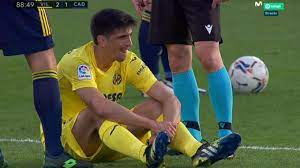


Utilizando el dataset proporcionado:
1. Busca la posición de Gerard y filtra el dataset para obtener los jugadores de la misma demarcación
2. Selecciona solo las variables numéricas y excluye las relacionadas con los porteros (goalkeeping_XXX)
3. Implementa un algoritmo k-means con el número de clusters adecuado
4. Obtén un dataframe con los jugadores que entren en el mismo cluster que Gerard, y ordénalos de mayor a menor valor de mercado

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('data_clustering/players_20.csv')
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Argues with Officials, Earl...",88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,"Long Throw-in, Selfish, Argues with Officials,...",84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Injury Free, Selfish, Early C...",87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,89.0,52.0,90.0,"Flair, Acrobatic Clearance",13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,

In [4]:
gmoreno = df.loc[df.short_name=='Gerard Moreno']

In [5]:
similar_pos = df.loc[df.player_positions=='ST, CF']
X = similar_pos._get_numeric_data()
X = X.drop(['gk_diving','gk_handling','gk_kicking','gk_reflexes','gk_speed','gk_positioning'], axis=1)

In [6]:
X = X.drop('nation_jersey_number', axis=1)
X = X.drop('release_clause_eur', axis=1)

In [7]:
X = X.drop(['team_jersey_number','goalkeeping_diving', 'goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes'], axis=1)
X = X.drop('sofifa_id', axis=1)
X =X.dropna()

In [8]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [9]:
X_new = normalize(X)

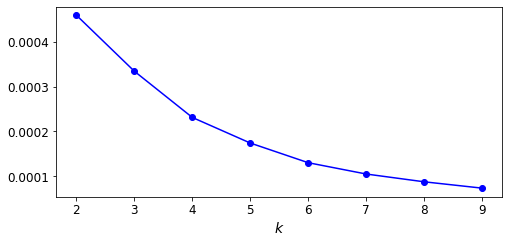

In [10]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_new) for k in range(2,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)

plt.show()

In [11]:
kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4.fit(X_new)
y_pred = kmeans_4.predict(X_new)


In [12]:
similar_pos = df.loc[df.player_positions=='ST, CF']
X = similar_pos._get_numeric_data()
X = X.drop(['gk_diving','gk_handling','gk_kicking','gk_reflexes','gk_speed','gk_positioning',
           'nation_jersey_number','release_clause_eur','team_jersey_number','goalkeeping_diving', 
           'goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes',
           'sofifa_id'], axis=1)
X['club'] = similar_pos.club
X['player_position'] = similar_pos.player_positions
X['short_name'] = similar_pos.short_name
X = X.dropna()
X['cluster'] = y_pred
X

,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,club,player_position,short_name,cluster
234,27,188,83,83,83,27500000,60000,1,3,4,2022.0,81.0,84.0,62.0,72.0,33.0,75.0,56,85,83,73,82,75,59,67,47,74,79,83,55,84,55,85,84,56,87,82,65,32,83,58,77,79,26,27,24,Atlético Mineiro,"ST, CF",Louri Beretta,0
367,27,180,77,81,82,21000000,45000,1,4,3,2023.0,76.0,79.0,66.0,78.0,45.0,69.0,61,80,80,75,81,79,70,56,56,80,75,77,72,78,67,80,75,73,72,78,55,40,80,62,75,72,43,41,41,Villarreal CF,"ST, CF",Gerard Moreno,0
1248,27,178,72,77,77,9500000,26000,1,3,3,2022.0,81.0,77.0,60.0,73.0,24.0,64.0,57,76,77,65,72,72,61,55,58,73,81,81,79,73,77,85,56,61,72,77,52,23,75,56,56,78,20,14,15,Botafogo,"ST, CF",Formosandrinho,0
1603,31,180,71,76,76,7000000,30000,1,3,3,2022.0,76.0,76.0,61.0,73.0,30.0,64.0,61,78,77,62,77,76,62,63,55,75,73,78,62,79,56,76,55,61,69,73,57,34,72,65,64,65,22,23,22,Cruzeiro,"ST, CF",Dênildo Stein,2
1657,21,185,70,75,83,10000000,14000,1,4,3,2023.0,84.0,71.0,61.0,75.0,40.0,70.0,57,78,69,68,58,77,52,45,52,75,83,84,74,69,65,72,92,68,75,58,55,37,78,65,61,68,41,35,32,Genoa,"ST, CF",C. Kouamé,0
1874,26,178,72,75,76,8000000,39000,1,4,3,2022.0,77.0,72.0,68.0,78.0,41.0,62.0,70,75,73,74,73,80,65,46,59,77,78,76,74,74,77,72,76,71,60,66,50,39,76,70,62,75,43,33,30,Newcastle United,"ST, CF",Y. Mutō,2
1883,33,180,72,75,75,4200000,38000,2,3,4,2020.0,58.0,78.0,73.0,78.0,32.0,66.0,61,82,66,75,75,78,84,83,69,78,66,51,79,75,70,75,73,66,69,75,58,45,77,77,78,74,25,22,24,Al Hilal,"ST, CF",Jonatan Soriano,3
2058,29,183,78,75,75,6500000,15000,1,2,4,2019.0,67.0,76.0,66.0,76.0,36.0,77.0,64,78,68,66,77,76,75,72,61,78,65,68,77,74,69,79,81,80,76,69,73,51,75,69,71,74,25,27,30,Urawa Red Diamonds,"ST, CF",Fabrício,0
2634,27,180,76,74,74,6000000,15000,1,3,3,2022.0,83.0,72.0,58.0,74.0,29.0,59.0,61,74,73,61,76,73,55,56,52,71,82,83,81,77,77,70,56,59,66,71,44,44,71,55,72,77,10,25,24,Atlético Paranaense,"ST, CF",Erick Gameira,0
2710,24,183,72,73,80,5500000,5000,1,3,3,2021.0,71.0,70.0,59.0,71.0,37.0,64.0,51,74,74,71,63,71,51,34,54,70,73,69,77,69,71,71,75,65,68,64,50,32,76,59,62,60,53,18,17,Chievo Verona,"ST, CF",M. Stępiński,0


In [13]:
gmoreno = X.loc[X.short_name=='Gerard Moreno']

In [14]:
gmoreno

,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,club,player_position,short_name,cluster
367,27,180,77,81,82,21000000,45000,1,4,3,2023.0,76.0,79.0,66.0,78.0,45.0,69.0,61,80,80,75,81,79,70,56,56,80,75,77,72,78,67,80,75,73,72,78,55,40,80,62,75,72,43,41,41,Villarreal CF,"ST, CF",Gerard Moreno,0


In [15]:
final_scout = X.loc[X['cluster']==0]
final_scout.sort_values('value_eur', ascending=False )
final_scout

,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,club,player_position,short_name,cluster
234,27,188,83,83,83,27500000,60000,1,3,4,2022.0,81.0,84.0,62.0,72.0,33.0,75.0,56,85,83,73,82,75,59,67,47,74,79,83,55,84,55,85,84,56,87,82,65,32,83,58,77,79,26,27,24,Atlético Mineiro,"ST, CF",Louri Beretta,0
367,27,180,77,81,82,21000000,45000,1,4,3,2023.0,76.0,79.0,66.0,78.0,45.0,69.0,61,80,80,75,81,79,70,56,56,80,75,77,72,78,67,80,75,73,72,78,55,40,80,62,75,72,43,41,41,Villarreal CF,"ST, CF",Gerard Moreno,0
1248,27,178,72,77,77,9500000,26000,1,3,3,2022.0,81.0,77.0,60.0,73.0,24.0,64.0,57,76,77,65,72,72,61,55,58,73,81,81,79,73,77,85,56,61,72,77,52,23,75,56,56,78,20,14,15,Botafogo,"ST, CF",Formosandrinho,0
1657,21,185,70,75,83,10000000,14000,1,4,3,2023.0,84.0,71.0,61.0,75.0,40.0,70.0,57,78,69,68,58,77,52,45,52,75,83,84,74,69,65,72,92,68,75,58,55,37,78,65,61,68,41,35,32,Genoa,"ST, CF",C. Kouamé,0
2058,29,183,78,75,75,6500000,15000,1,2,4,2019.0,67.0,76.0,66.0,76.0,36.0,77.0,64,78,68,66,77,76,75,72,61,78,65,68,77,74,69,79,81,80,76,69,73,51,75,69,71,74,25,27,30,Urawa Red Diamonds,"ST, CF",Fabrício,0
2634,27,180,76,74,74,6000000,15000,1,3,3,2022.0,83.0,72.0,58.0,74.0,29.0,59.0,61,74,73,61,76,73,55,56,52,71,82,83,81,77,77,70,56,59,66,71,44,44,71,55,72,77,10,25,24,Atlético Paranaense,"ST, CF",Erick Gameira,0
2710,24,183,72,73,80,5500000,5000,1,3,3,2021.0,71.0,70.0,59.0,71.0,37.0,64.0,51,74,74,71,63,71,51,34,54,70,73,69,77,69,71,71,75,65,68,64,50,32,76,59,62,60,53,18,17,Chievo Verona,"ST, CF",M. Stępiński,0
3335,22,182,75,72,82,5000000,3000,1,3,3,2020.0,69.0,70.0,62.0,71.0,34.0,63.0,61,73,73,66,60,72,62,64,57,70,68,69,71,71,65,74,76,67,67,62,47,29,71,57,72,67,40,22,21,Crotone,"ST, CF",L. Vido,0
3584,26,194,87,72,75,3900000,1000,1,3,2,2022.0,74.0,68.0,52.0,71.0,38.0,71.0,37,68,71,58,66,73,53,60,51,74,73,74,66,64,45,70,68,60,83,65,55,32,74,57,67,70,32,41,24,SK Slavia Praha,"ST, CF",A. Helal,0
4256,26,183,70,71,74,3000000,6000,1,3,3,2023.0,76.0,72.0,62.0,72.0,36.0,63.0,58,76,52,68,68,69,68,38,57,74,79,73,82,68,67,70,59,67,65,70,55,45,77,65,60,73,30,32,31,Suwon Samsung Bluewings,"ST, CF",A. Taggart,0


In [16]:
final_scout.columns

Index(['age', 'height_cm', 'weight_kg', 'overall', 'potential', 'value_eur',
       'wage_eur', 'international_reputation', 'weak_foot', 'skill_moves',
       'contract_valid_until', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'club', 'player_position', 

In [17]:
final_scout = final_scout.reindex(columns=['cluster','club','short_name','player_position','age', 'height_cm', 'weight_kg', 'overall', 'potential', 'value_eur',
       'wage_eur', 'international_reputation', 'weak_foot', 'skill_moves',
       'contract_valid_until', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle' ])
final_scout

,cluster,club,short_name,player_position,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
234,0,Atlético Mineiro,Louri Beretta,"ST, CF",27,188,83,83,83,27500000,60000,1,3,4,2022.0,81.0,84.0,62.0,72.0,33.0,75.0,56,85,83,73,82,75,59,67,47,74,79,83,55,84,55,85,84,56,87,82,65,32,83,58,77,79,26,27,24
367,0,Villarreal CF,Gerard Moreno,"ST, CF",27,180,77,81,82,21000000,45000,1,4,3,2023.0,76.0,79.0,66.0,78.0,45.0,69.0,61,80,80,75,81,79,70,56,56,80,75,77,72,78,67,80,75,73,72,78,55,40,80,62,75,72,43,41,41
1248,0,Botafogo,Formosandrinho,"ST, CF",27,178,72,77,77,9500000,26000,1,3,3,2022.0,81.0,77.0,60.0,73.0,24.0,64.0,57,76,77,65,72,72,61,55,58,73,81,81,79,73,77,85,56,61,72,77,52,23,75,56,56,78,20,14,15
1657,0,Genoa,C. Kouamé,"ST, CF",21,185,70,75,83,10000000,14000,1,4,3,2023.0,84.0,71.0,61.0,75.0,40.0,70.0,57,78,69,68,58,77,52,45,52,75,83,84,74,69,65,72,92,68,75,58,55,37,78,65,61,68,41,35,32
2058,0,Urawa Red Diamonds,Fabrício,"ST, CF",29,183,78,75,75,6500000,15000,1,2,4,2019.0,67.0,76.0,66.0,76.0,36.0,77.0,64,78,68,66,77,76,75,72,61,78,65,68,77,74,69,79,81,80,76,69,73,51,75,69,71,74,25,27,30
2634,0,Atlético Paranaense,Erick Gameira,"ST, CF",27,180,76,74,74,6000000,15000,1,3,3,2022.0,83.0,72.0,58.0,74.0,29.0,59.0,61,74,73,61,76,73,55,56,52,71,82,83,81,77,77,70,56,59,66,71,44,44,71,55,72,77,10,25,24
2710,0,Chievo Verona,M. Stępiński,"ST, CF",24,183,72,73,80,5500000,5000,1,3,3,2021.0,71.0,70.0,59.0,71.0,37.0,64.0,51,74,74,71,63,71,51,34,54,70,73,69,77,69,71,71,75,65,68,64,50,32,76,59,62,60,53,18,17
3335,0,Crotone,L. Vido,"ST, CF",22,182,75,72,82,5000000,3000,1,3,3,2020.0,69.0,70.0,62.0,71.0,34.0,63.0,61,73,73,66,60,72,62,64,57,70,68,69,71,71,65,74,76,67,67,62,47,29,71,57,72,67,40,22,21
3584,0,SK Slavia Praha,A. Helal,"ST, CF",26,194,87,72,75,3900000,1000,1,3,2,2022.0,74.0,68.0,52.0,71.0,38.0,71.0,37,68,71,58,66,73,53,60,51,74,73,74,66,64,45,70,68,60,83,65,55,32,74,57,67,70,32,41,24
4256,0,Suwon Samsung Bluewings,A. Taggart,"ST, CF",26,183,70,71,74,3000000,6000,1,3,3,2023.0,76.0,72.0,62.0,72.0,36.0,63.0,58,76,52,68,68,69,68,38,57,74,79,73,82,68,67,70,59,67,65,70,55,45,77,65,60,73,30,32,31


In [18]:
final_scout_1 = final_scout[['short_name','age','height_cm','weight_kg','overall','potential','value_eur',
                           'pace','shooting','passing','dribbling','defending','physic']]

In [19]:
final_scout_1.head()

,short_name,age,height_cm,weight_kg,overall,potential,value_eur,pace,shooting,passing,dribbling,defending,physic
234,Louri Beretta,27,188,83,83,83,27500000,81.0,84.0,62.0,72.0,33.0,75.0
367,Gerard Moreno,27,180,77,81,82,21000000,76.0,79.0,66.0,78.0,45.0,69.0
1248,Formosandrinho,27,178,72,77,77,9500000,81.0,77.0,60.0,73.0,24.0,64.0
1657,C. Kouamé,21,185,70,75,83,10000000,84.0,71.0,61.0,75.0,40.0,70.0
2058,Fabrício,29,183,78,75,75,6500000,67.0,76.0,66.0,76.0,36.0,77.0


In [20]:
final_scout_1.set_index('short_name', inplace=True)

In [26]:
final_scout_1.head()

,age,height_cm,weight_kg,overall,potential,value_eur,pace,shooting,passing,dribbling,defending,physic
short_name,,,,,,,,,,,,
Louri Beretta,27,188,83,83,83,27500000,81.0,84.0,62.0,72.0,33.0,75.0
Gerard Moreno,27,180,77,81,82,21000000,76.0,79.0,66.0,78.0,45.0,69.0
Formosandrinho,27,178,72,77,77,9500000,81.0,77.0,60.0,73.0,24.0,64.0
C. Kouamé,21,185,70,75,83,10000000,84.0,71.0,61.0,75.0,40.0,70.0
Fabrício,29,183,78,75,75,6500000,67.0,76.0,66.0,76.0,36.0,77.0


In [22]:
final_scout_1.head().T.to_excel('../../../PowerBI/clustering/gerard_moreno_scouting.xlsx', sheet_name='transpose')

In [23]:
final_scout.to_excel('../../../PowerBI/clustering/gerard_moreno_scouting.xlsx', sheet_name='cluster_0')

In [27]:
with pd.ExcelWriter('../../../PowerBI/clustering/gerard_moreno_scouting.xlsx') as writer:  
    final_scout.to_excel(writer, sheet_name='cluster_1')
    final_scout_1.head().to_excel(writer, sheet_name='transpose')